<a href="https://colab.research.google.com/github/gayoung-k/object-detection-learning-notes/blob/main/selective_search_iou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Deriving region proposal areas for object detection using selective search




#### Download selectivesearch and load the image
https://github.com/AlpacaTechJP/selectivesearch

In [6]:
!pip install selectivesearch

  Preparing metadata (setup.py) ... done
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4336 sha256=dda4165e3b302b122cb3312af2768b1ed7af91e034bc9abc9f95bfa8b1a4f739
  Stored in directory: /root/.cache/pip/wheels/7f/9b/c7/58b71f1e9fe4aa0ef8affd1c673f8818bc22a5091ea8cbbe93
Successfully built selectivesearch


In [5]:
!mkdir -p /content/data
!wget -O /content/data/audrey01.jpg https://raw.githubusercontent.com/gayoung-k/object-detection-learning-notes/main/images/audrey01.jpg


--2025-09-03 20:30:15--  https://raw.githubusercontent.com/gayoung-k/object-detection-learning-notes/main/images/audrey01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30102 (29K) [image/jpeg]
Saving to: ‘/content/data/audrey01.jpg’

/content/data/audre 100%[===================>]  29.40K  --.-KB/s    in 0.001s  

2025-09-03 20:30:15 (21.3 MB/s) - ‘/content/data/audrey01.jpg’ saved [30102/30102]



img shape: (450, 375, 3)


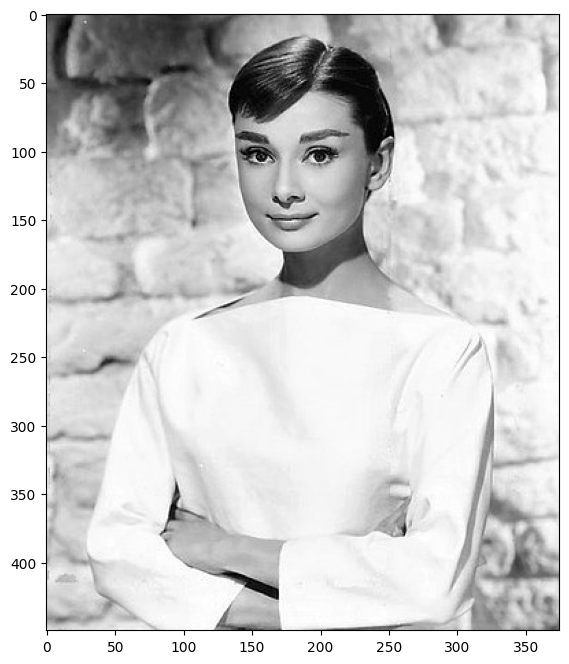

In [7]:
import selectivesearch
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

img = cv2.imread('./data/audrey01.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('img shape:', img.shape)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.show()

In [8]:
import selectivesearch

# selectivesearch.selective_search() returns the region proposal information of the image
_, regions = selectivesearch.selective_search(img_rgb, scale=100, min_size=2000)

print(type(regions), len(regions))


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


<class 'list'> 41


#### Viewing the information of the returned Region Proposals

The returned `regions` variable is of type list, and each element inside is a dictionary.

Meaning of each dictionary key:

* **rect**: contains the starting x, y coordinates along with width and height values, representing the bounding box of a detected object candidate.
* **size**: the size of the object segment selected by selective search.
* **labels**: unique IDs of the objects located inside the bounding box defined by `rect`.
* As you go further down, the bounding boxes have larger width and height values, and the probability increases that multiple objects may exist within a single bounding box.


In [9]:
# Print only the rect information
# cand_rects = [cand['rect'] for cand in regions]
# print(cand_rects)
cand_rects = []
for item in regions:
    cand_rects.append(item['rect'])

print(cand_rects)


[(0, 0, 107, 167), (15, 0, 129, 110), (121, 0, 253, 133), (134, 17, 73, 62), (166, 23, 87, 176), (136, 53, 88, 121), (232, 79, 117, 147), (50, 91, 133, 123), (305, 97, 69, 283), (0, 161, 70, 46), (72, 171, 252, 222), (0, 181, 118, 85), (106, 210, 89, 101), (302, 228, 66, 96), (0, 253, 92, 134), (153, 270, 173, 179), (0, 305, 47, 139), (104, 312, 80, 71), (84, 360, 91, 67), (0, 362, 171, 87), (297, 364, 77, 85), (0, 91, 183, 175), (136, 23, 117, 176), (72, 171, 254, 278), (134, 17, 119, 182), (302, 97, 72, 283), (121, 0, 253, 226), (0, 91, 183, 175), (0, 0, 144, 167), (0, 0, 253, 199), (0, 253, 92, 191), (0, 91, 183, 353), (0, 171, 326, 278), (0, 97, 374, 352), (84, 312, 100, 115), (0, 91, 184, 353), (0, 91, 195, 353), (0, 0, 374, 444), (0, 0, 374, 449), (0, 0, 374, 449), (0, 0, 374, 449)]


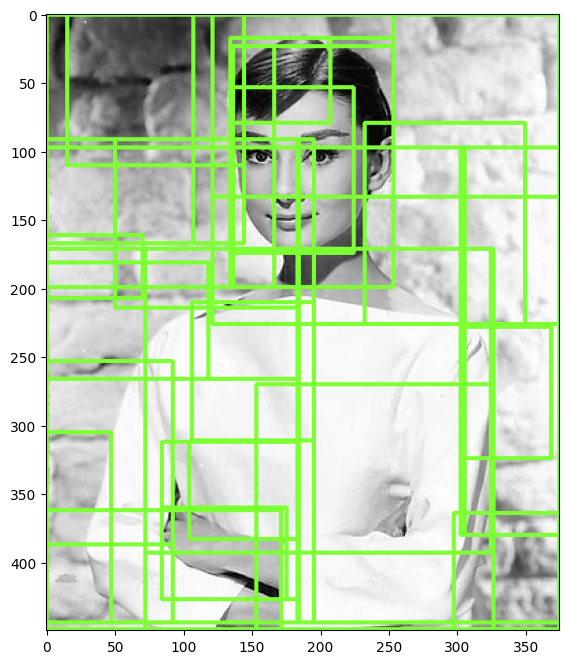

In [10]:
# Visualization using OpenCV's rectangle()
# rectangle() draws a box on the original image by taking the image,
# top-left coordinates, bottom-right coordinates, box color, thickness, etc. as input arguments.

green_rgb = (125, 255, 51)
img_rgb_copy = img_rgb.copy()
for rect in cand_rects:

    left = rect[0]
    top = rect[1]
    # rect[2] and rect[3] are width and height, so add them to the top-left coordinates
    # to obtain the bottom-right coordinates.
    right = left + rect[2]
    bottom = top + rect[3]

    img_rgb_copy = cv2.rectangle(img_rgb_copy, (left, top), (right, bottom), color=green_rgb, thickness=2)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb_copy)
plt.show()


#### Extract only candidates with large bounding box sizes


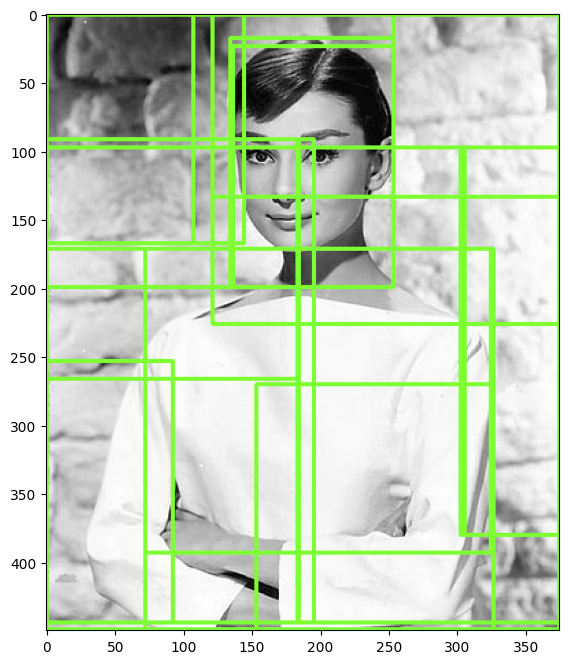

In [11]:
cand_rects = [cand['rect'] for cand in regions if cand['size'] > 10000]

green_rgb = (125, 255, 51)
img_rgb_copy = img_rgb.copy()
for rect in cand_rects:

    left = rect[0]
    top = rect[1]
    # rect[2] and rect[3] are width and height, so add them to the top-left coordinates
    # to obtain the bottom-right coordinates.
    right = left + rect[2]
    bottom = top + rect[3]

    img_rgb_copy = cv2.rectangle(img_rgb_copy, (left, top), (right, bottom), color=green_rgb, thickness=2)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb_copy)
plt.show()


### Calculate IOU

#### Create a function that takes candidate boxes and ground truth boxes as input arguments and calculates the IOU


In [12]:
import numpy as np

def compute_iou(cand_box, gt_box):

    # Calculate intersection areas
    x1 = np.maximum(cand_box[0], gt_box[0])
    y1 = np.maximum(cand_box[1], gt_box[1])
    x2 = np.minimum(cand_box[2], gt_box[2])
    y2 = np.minimum(cand_box[3], gt_box[3])

    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)

    cand_box_area = (cand_box[2] - cand_box[0]) * (cand_box[3] - cand_box[1])
    gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    union = cand_box_area + gt_box_area - intersection

    iou = intersection / union
    return iou

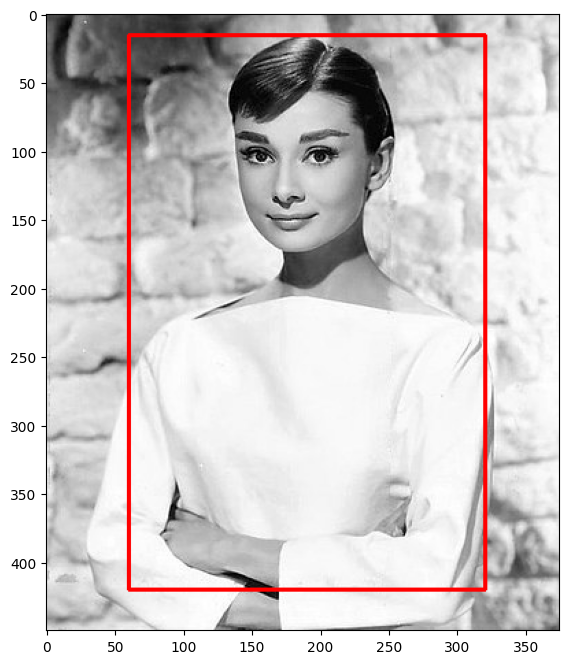

In [13]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Assume that the coordinates of the actual box (Ground Truth) are as follows.
gt_box = [60, 15, 320, 420]


img = cv2.imread('./data/audrey01.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

red = (255, 0 , 0)
img_rgb = cv2.rectangle(img_rgb, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), color=red, thickness=2)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.show()

In [14]:
import selectivesearch

# selectivesearch.selective_search() returns the region proposal information of the image
img = cv2.imread('./data/audrey01.jpg')
img_rgb2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
_, regions = selectivesearch.selective_search(img_rgb2, scale=100, min_size=2000)

print(type(regions), len(regions))


<class 'list'> 41


In [15]:
[cand['rect'] for cand in regions]

[(0, 0, 107, 167),
 (15, 0, 129, 110),
 (121, 0, 253, 133),
 (134, 17, 73, 62),
 (166, 23, 87, 176),
 (136, 53, 88, 121),
 (232, 79, 117, 147),
 (50, 91, 133, 123),
 (305, 97, 69, 283),
 (0, 161, 70, 46),
 (72, 171, 252, 222),
 (0, 181, 118, 85),
 (106, 210, 89, 101),
 (302, 228, 66, 96),
 (0, 253, 92, 134),
 (153, 270, 173, 179),
 (0, 305, 47, 139),
 (104, 312, 80, 71),
 (84, 360, 91, 67),
 (0, 362, 171, 87),
 (297, 364, 77, 85),
 (0, 91, 183, 175),
 (136, 23, 117, 176),
 (72, 171, 254, 278),
 (134, 17, 119, 182),
 (302, 97, 72, 283),
 (121, 0, 253, 226),
 (0, 91, 183, 175),
 (0, 0, 144, 167),
 (0, 0, 253, 199),
 (0, 253, 92, 191),
 (0, 91, 183, 353),
 (0, 171, 326, 278),
 (0, 97, 374, 352),
 (84, 312, 100, 115),
 (0, 91, 184, 353),
 (0, 91, 195, 353),
 (0, 0, 374, 444),
 (0, 0, 374, 449),
 (0, 0, 374, 449),
 (0, 0, 374, 449)]

In [16]:
cand_rects = [cand['rect'] for cand in regions]
for index, cand_box in enumerate(cand_rects):
    cand_box = list(cand_box) # tuple -> list
    cand_box[2] += cand_box[0] # cand_box has x, y, w, h
    cand_box[3] += cand_box[1]

    iou = compute_iou(cand_box, gt_box)
    print('index:', index, "iou:", iou)

index: 0 iou: 0.06157293686705451
index: 1 iou: 0.07156308851224105
index: 2 iou: 0.2033654637255666
index: 3 iou: 0.04298195631528965
index: 4 iou: 0.14541310541310543
index: 5 iou: 0.10112060778727446
index: 6 iou: 0.11806905615946989
index: 7 iou: 0.1420163334272036
index: 8 iou: 0.035204259342190375
index: 9 iou: 0.004256894317971497
index: 10 iou: 0.5184766640298338
index: 11 iou: 0.04465579710144928
index: 12 iou: 0.0853656220322887
index: 13 iou: 0.015722240419259743
index: 14 iou: 0.037833068643021
index: 15 iou: 0.22523535071077264
index: 16 iou: 0.0
index: 17 iou: 0.053941120607787274
index: 18 iou: 0.05154006626579948
index: 19 iou: 0.05660327592118798
index: 20 iou: 0.01165009904393209
index: 21 iou: 0.18588082901554404
index: 22 iou: 0.19555555555555557
index: 23 iou: 0.5409250175192712
index: 24 iou: 0.205679012345679
index: 25 iou: 0.042245111210628454
index: 26 iou: 0.34848824374009246
index: 27 iou: 0.18588082901554404
index: 28 iou: 0.10952135872362326
index: 29 iou: 

In [17]:
cand_rects = [cand['rect'] for cand in regions if cand['size'] > 5000]
cand_rects.sort()
cand_rects

[(0, 0, 107, 167),
 (0, 0, 144, 167),
 (0, 0, 253, 199),
 (0, 0, 374, 444),
 (0, 0, 374, 449),
 (0, 0, 374, 449),
 (0, 0, 374, 449),
 (0, 91, 183, 175),
 (0, 91, 183, 175),
 (0, 91, 183, 353),
 (0, 91, 184, 353),
 (0, 91, 195, 353),
 (0, 97, 374, 352),
 (0, 171, 326, 278),
 (0, 181, 118, 85),
 (0, 253, 92, 134),
 (0, 253, 92, 191),
 (0, 362, 171, 87),
 (15, 0, 129, 110),
 (50, 91, 133, 123),
 (72, 171, 252, 222),
 (72, 171, 254, 278),
 (84, 312, 100, 115),
 (121, 0, 253, 133),
 (121, 0, 253, 226),
 (134, 17, 119, 182),
 (136, 23, 117, 176),
 (153, 270, 173, 179),
 (166, 23, 87, 176),
 (232, 79, 117, 147),
 (297, 364, 77, 85),
 (302, 97, 72, 283),
 (305, 97, 69, 283)]

img shape: (450, 375, 3)
index: 32 iou: 0.6341234282410753 rectangle: (0, 0, 374, 444)
index: 33 iou: 0.6270619201314865 rectangle: (0, 0, 374, 449)
index: 34 iou: 0.6270619201314865 rectangle: (0, 0, 374, 449)
index: 35 iou: 0.6270619201314865 rectangle: (0, 0, 374, 449)


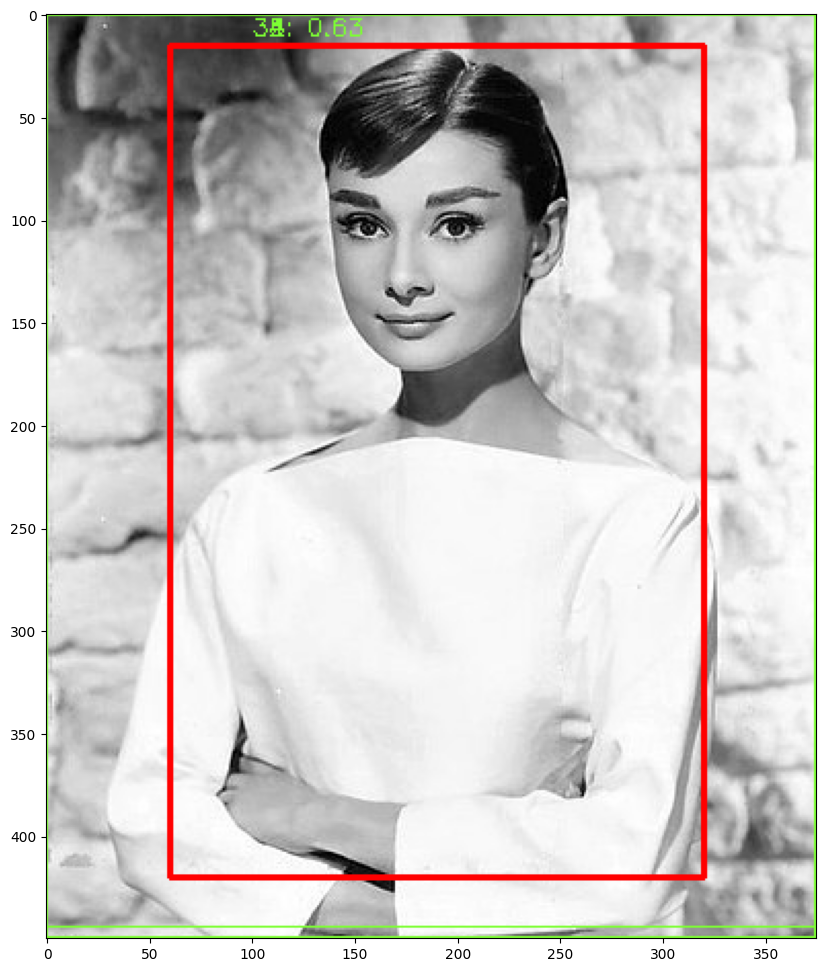

In [18]:
img = cv2.imread('./data/audrey01.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('img shape:', img.shape)

green_rgb = (125, 255, 51)
cand_rects = [cand['rect'] for cand in regions if cand['size'] > 3000]
gt_box = [60, 15, 320, 420]
img_rgb = cv2.rectangle(img_rgb, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), color=red, thickness=2)

for index, cand_box in enumerate(cand_rects):

    cand_box = list(cand_box)
    cand_box[2] += cand_box[0]
    cand_box[3] += cand_box[1]

    iou = compute_iou(cand_box, gt_box)

    if iou > 0.6:
        print('index:', index, "iou:", iou, 'rectangle:',(cand_box[0], cand_box[1], cand_box[2], cand_box[3]) )
        cv2.rectangle(img_rgb, (cand_box[0], cand_box[1]), (cand_box[2], cand_box[3]), color=green_rgb, thickness=1)
        text = "{}: {:.2f}".format(index, iou)
        cv2.putText(img_rgb, text, (cand_box[0]+ 100, cand_box[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color=green_rgb, thickness=1)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.show()
